# **Imports**
*Create easily interpretable topics with BERTopic and LLMs*
<br>



---
        
💡 **NOTE**: We will want to use a GPU to run both 7B LLMs as well as BERTopic for this use case. In Google Colab, go to
**Runtime > Change runtime type > Hardware accelerator > GPU > GPU type > T4**.

---

We will start by installing a number of packages that we are going to use throughout this example:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture

# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
!pip install bertopic datasets

# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git
!pip install datamapplot/.

# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

In [ ]:
!wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/TheBloke/dolphin-2.7-mixtral-8x7b-GGUF/resolve/main/dolphin-2.7-mixtral-8x7b.Q3_K_M.gguf

from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path="openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"])

--2024-02-02 21:12:09--  https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 18.172.134.124, 18.172.134.88, 18.172.134.4, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/65/3b/653b1cc7a4558cd22c0ac02df471105878a080cb5694622ccd566697c574592f/cd58120326971c71c0590f6b7084a0744e287ce9c67275d8b4bf34a5947d950b?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27openhermes-2.5-mistral-7b.Q4_K_M.gguf%3B+filename%3D%22openhermes-2.5-mistral-7b.Q4_K_M.gguf%22%3B&Expires=1707167529&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNzE2NzUyOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzY1LzNiLzY1M2IxY2M3YTQ1NThjZDIyYzBhYzAyZGY0NzExMDU4NzhhMDgwY2I1Njk0NjIyY2NkNTY2Njk3YzU3ND

AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 
Model metadata: {'tokenizer.ggml.padding_token_id': '0', 'tokenizer.ggml.eos_token_id': '32000', 'general.architecture': 'llama', 'llama.rope.freq_base': '10000.000000', 'llama.context_length': '32768', 'general.name': 'teknium_openhermes-2.5-mistral-7b', 'llama.embedding_length': '4096', 'llama.feed_forward_length': '14336', 'llama.attention.layer_norm_rms_epsilon': '0.000010', 'llama.rope.dimension_count': '128', 'tokenizer.ggml.bos_token_id': '1', 'llama.attention.head_count': '32', 'llama.block_count': '32', 'llama.attention.head_count_kv': '8', 'general.quantization_version': '2', 'tokenizer.ggml.model': 'llama', 'general.file_type': '15'}


In [ ]:
!unzip /content/drive/MyDrive/Subasish/CN_NLP/SUV_Bicycle/names-surnames-list-master.zip

Archive:  /content/drive/MyDrive/Subasish/CN_NLP/SUV_Bicycle/names-surnames-list-master.zip
36b083028e7cbebaacd77c79cdb42341d7fad3da
   creating: names-surnames-list-master/
 extracting: names-surnames-list-master/.gitignore  
   creating: names-surnames-list-master/.idea/
  inflating: names-surnames-list-master/.idea/NamesSurnamesList.iml  
   creating: names-surnames-list-master/.idea/inspectionProfiles/
  inflating: names-surnames-list-master/.idea/inspectionProfiles/Project_Default.xml  
  inflating: names-surnames-list-master/.idea/inspectionProfiles/profiles_settings.xml  
  inflating: names-surnames-list-master/.idea/misc.xml  
  inflating: names-surnames-list-master/.idea/modules.xml  
  inflating: names-surnames-list-master/.idea/vcs.xml  
  inflating: names-surnames-list-master/README.md  
  inflating: names-surnames-list-master/female-names-list.txt  
  inflating: names-surnames-list-master/male-names-list.txt  
  inflating: names-surnames-list-master/names-surnames-finder.p

# SUV Bicycle Topic Modeling

## **Data**


In [ ]:
from datasets import load_dataset
import pandas as pd
import re



df = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/SUV_Bicycle/SUV_Bicycle.csv', encoding = 'latin1')



df['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Injury possible', 'Minor injury suspected')
df['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Fatal', 'Serious injury suspected')
# Print the updated DataFrame
print(df['CRASH_SEVERITY_CD'].value_counts())

df['CRASH_YR'] = df['CRASH_YR'].astype(str)
# First, extract the 'base_predictions' and 'created_at' columns
sentiments_by_year = df[['CRASH_SEVERITY_CD', 'CRASH_YR']]

# Extract the year from the 'created_at' column and create a new column for it
sentiments_by_year['year'] = sentiments_by_year['CRASH_YR'].str[:4]

# Replace 'NaN' values in the 'year' column with 'no_date'
sentiments_by_year['year'].fillna('no_date', inplace=True)

# Group the data by 'year' and 'base_predictions', and then count the occurrences
sentiments_count_by_year = sentiments_by_year.groupby(['year', 'CRASH_SEVERITY_CD']).size().unstack(fill_value=0)

# Rename the columns for better clarity
sentiments_count_by_year.columns = ['Minor injury suspected', 'Property damage only', 'Serious injury suspected']

# Calculate the 'Total' column as the sum of Negative, Neutral, and Positive counts
sentiments_count_by_year['Total'] = sentiments_count_by_year[['Minor injury suspected', 'Property damage only', 'Serious injury suspected']].sum(axis=1)

# Convert the DataFrame to a new DataFrame with reset index
df_sentiments_count_by_year = pd.DataFrame(sentiments_count_by_year.reset_index())

# Add a row for the total count of each sentiment for all years
total_row = df_sentiments_count_by_year[['Minor injury suspected', 'Property damage only', 'Serious injury suspected', 'Total']].sum()
total_row['year'] = 'Total'
df_sentiments_count_by_year = df_sentiments_count_by_year.append(total_row, ignore_index=True)

# Display the new DataFrame
print(df_sentiments_count_by_year)

len(df)


Minor injury suspected      989
Property damage only        231
Serious injury suspected    179
Name: CRASH_SEVERITY_CD, dtype: int64
    year  Minor injury suspected  Property damage only  \
0   2017                     256                    54   
1   2018                     222                    51   
2   2019                     185                    48   
3   2020                     143                    43   
4   2021                     183                    35   
5  Total                     989                   231   

   Serious injury suspected  Total  
0                        39    349  
1                        35    308  
2                        28    261  
3                        32    218  
4                        45    263  
5                       179   1399  


<ipython-input-4-9b26890904d9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiments_by_year['year'] = sentiments_by_year['CRASH_YR'].str[:4]
<ipython-input-4-9b26890904d9>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiments_by_year['year'].fillna('no_date', inplace=True)
<ipython-input-4-9b26890904d9>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sentiments_count_by_year = df_sentiments_count_by_year.append(total_row, ignore_index=True)


1399

### Preprocessing

In [ ]:
from nltk.corpus import stopwords
import spacy
from concurrent.futures import ProcessPoolExecutor
import cProfile

In [ ]:
df = df[df['Narrative'] != 'NA']
# Remove rows with 'NA;' in the 'narrative' column
df.drop(df[df['Narrative'] == 'NA'].index, inplace=True)
len(df)

1399

In [ ]:
df['clean_Narrative'] = df['Narrative']

In [ ]:
df.drop(df[df['Narrative'] == 'see narrative and diagram at right'].index, inplace=True)
df.drop(df[df['Narrative'] == 'see oh-2'].index, inplace=True)

In [ ]:


# Assuming your DataFrame is named 'df', you can create a new DataFrame for the analysis
story_analysis = pd.DataFrame()

# Number of rows
story_analysis['Number of Rows'] = [len(df)]

# Word count for each row in the 'Narrative' column
story_analysis['Word Count'] = df['clean_Narrative'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0).sum()

# Character count for each row in the 'Narrative' column
story_analysis['Character Count'] = df['clean_Narrative'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0).sum()

# Average word count
story_analysis['Average Word Count'] = story_analysis['Word Count'] / len(df)

# Average character count
story_analysis['Average Character Count'] = story_analysis['Character Count'] / len(df)

# Display the analysis DataFrame
print(story_analysis)

# Save the analysis to a CSV file
#story_analysis.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/SUV_Bicycle/story_raw_analysis_SUV.csv', index=False)


   Number of Rows  Word Count  Character Count  Average Word Count  \
0            1393       57475           305071           41.259871   

   Average Character Count  
0               219.002872  


Names lists: https://github.com/dominictarr/random-name

In [ ]:

# Load the names from the files
female_names = set(pd.read_csv('/content/names-surnames-list-master/female-names-list.txt', header=None)[0].str.lower())
male_names = set(pd.read_csv('/content/names-surnames-list-master/male-names-list.txt', header=None)[0].str.lower())
surnames = set(pd.read_csv('//content/names-surnames-list-master/surnames-list.txt', header=None)[0].str.lower())

# Combine all names into a single set
all_names = female_names.union(female_names, male_names, surnames)

import numpy as np

# Function to remove names from the clean_Narrative column
def remove_names(text):
    if pd.isna(text):
        return text  # Return unchanged for NaN values
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in all_names]
    return ' '.join(filtered_words)

# Apply the function to the 'clean_Narrative' column
df['clean_Narrative'] = df['clean_Narrative'].apply(remove_names)



In [ ]:

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Function to remove stop words using spaCy
def remove_stop_words(text):
    if pd.isna(text):
        return ""
    doc = nlp(text)
    filtered_words = [token.text for token in doc if not token.is_stop]
    return " ".join(filtered_words)

# Function to process a batch of rows
def process_batch(data):
    return data.apply(remove_stop_words)

# Function to batch process the entire DataFrame
def batch_process(data, batch_size=1000):
    chunks = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_batch, chunks))
    return pd.concat(results)

# Profile the function
with cProfile.Profile() as pr:
    df['clean_Narrative'] = batch_process(df['clean_Narrative'])

# Display the profiling results
#pr.print_stats()


In [ ]:




# Lemmatization function using spaCy
def lemmatize(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

# Applying lemmatization and removal of inflectional endings
def preprocess(text):
    lemmatized_text = lemmatize(text)
    # Add any additional preprocessing steps here if needed
    return lemmatized_text

# Function to process a batch of rows
def process_batch(data):
    return data.apply(preprocess)

# Function to batch process the entire DataFrame
def batch_process(data, batch_size=1000):
    chunks = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_batch, chunks))
    return pd.concat(results)

# Profile the function
with cProfile.Profile() as pr:
    df['clean_Narrative'] = batch_process(df['clean_Narrative'])


In [ ]:

stop_phrases = {
    'unit','number'
  }
# Create a compiled regex pattern
stop_phrases_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, stop_phrases)) + r')\b')

def remove_stop_phrases(text):
    # Use a single substitution
    return stop_phrases_pattern.sub(' ', text)

# Apply the function to the 'clean_Narrative' column
df['clean_Narrative'] = df['clean_Narrative'].apply(remove_stop_phrases)

In [ ]:

# Define a regular expression pattern to match and remove text inside parentheses
pattern = r'\([^)]*\)'

# Use str.replace() to remove instances of 'i-XXXX'
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match 'i-XXXX' where XXX can be any digit from 1 to 4
pattern = r'i-[1-4]'

# Use str.replace() to remove instances of 'i-XXXX'
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match 'i-XXXX' where XXX can be any digit from 1 to 4
pattern = r'i[1-4]'

# Use str.replace() to remove instances of 'i-XXXX'
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')


# Define a regular expression pattern to match numbers with ordinal suffixes
pattern = r'\b\d{1,4}(?:th|rd|rth|nd|st)\b'

# Use str.replace() to remove numbers with ordinal suffixes
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match the specified pattern
pattern = r'\b[A-Za-z]{2,}\d+[A-Za-z]{2,}\b'

# Use str.replace() to replace the matched pattern with an empty string
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '', regex=True)

# Define a regular expression pattern to match and remove numbers
pattern_remove_numbers = r'\b\d+\b'  # This pattern matches standalone numbers

# Use str.replace() to remove standalone numbers
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern_remove_numbers, '')

# Define a regular expression pattern to match 'unitX' where X is a number
pattern_unit_numbers = r'unit\d'
# Use str.replace() to keep 'unitX' numbers
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern_unit_numbers, lambda x: x.group(0))

# Define a regular expression pattern to remove '#' or '-' or ','
pattern = r'[@#*\-]'

# Use str.replace() to remove the specified characters
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match the specified pattern
pattern = r'\b[A-Za-z]{1,2}\d{1,6}\b'

# Use str.replace() to remove the specified characters
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')

# Define a regular expression pattern to match the specified pattern
pattern2 = r'[A-Za-z]{2,}\d+[A-Za-z]{2,}'

# Use str.replace() to remove the specified characters
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern2, '')


# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' r ', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' b ', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' n ', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' am ', ' ')
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' pm ', ' ')
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' :am ', ' ')
# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' :pm ', ' ')

# Use str.replace() to delete all '0' characters
df['clean_Narrative'] = df['clean_Narrative'].str.replace('0', '')


# Define a function to remove numbers not preceded by 'unit'
def remove_numbers_not_preceded_by_unit(text):
    # Use str.replace() to remove numbers not preceded by 'unit'
    return text.replace('unit', 'unit ').replace(' unit', '').replace('unit', '').strip()




# Apply the function to the 'clean_Narrative' column
#df['clean_Narrative'] = df['clean_Narrative'].apply(remove_numbers_not_preceded_by_unit)


# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' // ', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r'/', ' ')

# Use str.replace() with a regular expression to remove 'r' with spaces around it
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r' * ', ' ')

# Use a lambda function to remove '/' characters
#df['clean_Narrative'] = df['clean_Narrative'].apply(lambda x: x.replace('/', ''))



<ipython-input-16-ebc3af0b8f26>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')
<ipython-input-16-ebc3af0b8f26>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')
<ipython-input-16-ebc3af0b8f26>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')
<ipython-input-16-ebc3af0b8f26>:24: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '')
<ipython-input-16-ebc3af0b8f26>:36: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace

In [ ]:

# Define a regular expression pattern to match instances like 'iXXn', 'iXXs', 'iXXw', 'iXXe'
pattern = r'i\d{2}[nswne]'

# Use str.replace() to replace the matched pattern with an empty string
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '', regex=True)

# Define a regular expression pattern to match instances like 'iXXn', 'iXXs', 'iXXw', 'iXXe'
pattern = r'i\d{1}[nswne]'

# Use str.replace() to replace the matched pattern with an empty string
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '', regex=True)

# Define a regular expression pattern to match instances like 'iXXn', 'iXXs', 'iXXw', 'iXXe'
pattern = r'i\d{3}[nswne]'

# Use str.replace() to replace the matched pattern with an empty string
df['clean_Narrative'] = df['clean_Narrative'].str.replace(pattern, '', regex=True)

# Remove double spaces
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r'\s+', ' ', regex=True)


In [ ]:
df['clean_Narrative'].head(20)

0      travel downhill princeton run stop sign make ...
1     accident occur n. st . , e. ave . northbound n...
2                                                      
3      travel e st . travel broadway . directly . tr...
4      travel soutbound ln crossing columbia pkwy . ...
5      state left turn rombach avenue wait turn leav...
6                                                      
7                                                      
8                                                      
9                                                      
10                                                     
11     state : drive s s. belvoir blvd second curb a...
12                                                     
13                                                     
14                                                     
15                                                     
16                                                     
17                                              

In [ ]:

# Assuming you have the DataFrame 'df' with the 'Story' column
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r'\s+', ' ')

df['clean_Narrative'] = df['clean_Narrative'].str.lower()

#Remove symbols
df['clean_Narrative'] = df['clean_Narrative'].str.replace(r"[—“,.:\";=()$|%’/•\d\\]", "")

#remove dashes (-)
df['clean_Narrative'] = df['clean_Narrative'].apply(lambda x: x.replace('-', '').replace('  ', ' '))



<ipython-input-19-52400eb4d33c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace(r'\s+', ' ')
<ipython-input-19-52400eb4d33c>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_Narrative'] = df['clean_Narrative'].str.replace(r"[—“,.:\";=()$|%’/•\d\\]", "")


In [ ]:


# Assuming your DataFrame is named 'df', you can create a new DataFrame for the analysis
story_analysis = pd.DataFrame()

# Number of rows
story_analysis['Number of Rows'] = [len(df)]

# Word count for each row in the 'Story' column
story_analysis['Word Count'] = df['clean_Narrative'].apply(lambda x: len(x.split())).sum()

# Character count for each row in the 'Story' column
story_analysis['Character Count'] = df['clean_Narrative'].apply(lambda x: len(x)).sum()

# Average word count
story_analysis['Average Word Count'] = story_analysis['Word Count'].mean()

# Average character count
story_analysis['Average Character Count'] = story_analysis['Character Count'].mean()



# Save the analysis to a CSV file
#story_analysis.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/SUV_Bicycle/processed_SUV.csv', index=False)


In [ ]:
len(df)

1393

In [ ]:
import pandas as pd

# Assuming df is your DataFrame with 'clean_Narrative' column
df['clean_Narrative'] = df['clean_Narrative'].str.replace('  ', ' ')



In [ ]:

stop_phrases = {
    'ir'
  }
# Create a compiled regex pattern
stop_phrases_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, stop_phrases)) + r')\b')

def remove_stop_phrases(text):
    # Use a single substitution
    return stop_phrases_pattern.sub(' ', text)

# Apply the function to the 'clean_Narrative' column
df['clean_Narrative'] = df['clean_Narrative'].apply(remove_stop_phrases)

In [ ]:




# Split the 'Story' column into words and count the number of words
df['Word_Count'] = df['clean_Narrative'].str.split().apply(len)

# Filter rows with at least 5 words
df = df[df['Word_Count'] >= 10]

# Drop the 'Word_Count' column if you don't need it anymore
df = df.drop(columns=['Word_Count'])



In [ ]:
len(df)

698

In [ ]:
df['CRASH_YR'] = df['CRASH_YR'].astype(str)
# First, extract the 'base_predictions' and 'created_at' columns
sentiments_by_year = df[['CRASH_SEVERITY_CD', 'CRASH_YR']]

# Extract the year from the 'created_at' column and create a new column for it
sentiments_by_year['year'] = sentiments_by_year['CRASH_YR'].str[:4]

# Replace 'NaN' values in the 'year' column with 'no_date'
sentiments_by_year['year'].fillna('no_date', inplace=True)

# Group the data by 'year' and 'base_predictions', and then count the occurrences
sentiments_count_by_year = sentiments_by_year.groupby(['year', 'CRASH_SEVERITY_CD']).size().unstack(fill_value=0)

# Rename the columns for better clarity
sentiments_count_by_year.columns = ['Minor injury suspected', 'Property damage only', 'Serious injury suspected']

# Calculate the 'Total' column as the sum of Negative, Neutral, and Positive counts
sentiments_count_by_year['Total'] = sentiments_count_by_year[['Minor injury suspected', 'Property damage only', 'Serious injury suspected']].sum(axis=1)

# Convert the DataFrame to a new DataFrame with reset index
df_sentiments_count_by_year = pd.DataFrame(sentiments_count_by_year.reset_index())

# Add a row for the total count of each sentiment for all years
total_row = df_sentiments_count_by_year[['Minor injury suspected', 'Property damage only', 'Serious injury suspected', 'Total']].sum()
total_row['year'] = 'Total'
df_sentiments_count_by_year = df_sentiments_count_by_year.append(total_row, ignore_index=True)

# Display the new DataFrame
print(df_sentiments_count_by_year)

    year  Minor injury suspected  Property damage only  \
0   2017                      33                    12   
1   2018                     130                    30   
2   2019                      92                    24   
3   2020                     103                    30   
4   2021                     131                    25   
5  Total                     489                   121   

   Serious injury suspected  Total  
0                         7     52  
1                        17    177  
2                        14    130  
3                        21    154  
4                        29    185  
5                        88    698  


<ipython-input-26-f731d1ae85c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiments_by_year['year'] = sentiments_by_year['CRASH_YR'].str[:4]
<ipython-input-26-f731d1ae85c9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiments_by_year['year'].fillna('no_date', inplace=True)
<ipython-input-26-f731d1ae85c9>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sentiments_count_by_year = df_sentiments_count_by_year.append(total_row, ignore_index=True)


In [ ]:
df['clean_Narrative'].iloc[100]

' travel w frebis ave approach lisle alley travel e frebis ave approach lisle ride shoulder pass lisle alley turn s lisle strike rear cause fall ground flee s lisle alley transport hospital stable condition treat er staff shoulder pain '

In [ ]:
df['Narrative'].iloc[100]

'unit #1 was traveling w/b on frebis ave approaching lisle alley. unit #2 was traveling e/b on frebis ave also approaching lisle alley riding on the shoulder. as unit #2 was passing lisle alley, the driver of unit #1 turned s/b on lisle alley striking the rear of unit #2 causing the rider of unit #2 to fall to the ground. the driver of unit #1 then fled s/b on lisle alley. the rider of unit #2 was transported to grant hospital in stable condition. the rider of unit #2 was treated by grant er staff for back and shoulder pain.'

In [ ]:
df.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/SUV_Bicycle/processed_SUV.csv')

## **Quantized LLM**

To use a quantized LLMs, we make use of the `GGUF` format together with `llama-cpp-python`. When you access any of [TheBloke's quantized models](https://huggingface.co/TheBloke), you can click on files and find specific quantized formats. We are going with a 4-bit quantized model:

We pass the LLM to BERTopic with a custom prompt. Let's add `KeyBERTInspired` representations to compare the LLM representations with:

In [ ]:
from bertopic.representation import KeyBERTInspired, LlamaCPP

df = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/SUV_Bicycle/processed_SUV.csv', encoding = 'latin1')

docs = df['clean_Narrative'].tolist()


story_list = [str(item) for item in docs]

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

## **Embedding and Clustering**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.


In [ ]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=6, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Tokenize
#vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

# Weighing scheme
#ctfidf_model = ClassTfidfTransformer()

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

## **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  #nr_topics=5,
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-01-24 00:14:57,453 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-24 00:14:57,498 - BERTopic - Dimensionality - Completed ✓
2024-01-24 00:14:57,500 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-24 00:14:57,727 - BERTopic - Cluster - Completed ✓
2024-01-24 00:14:57,735 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 12/12 [00:08<00:00,  1.49it/s]
2024-01-24 00:15:06,352 - BERTopic - Representation - Completed ✓


Now that we are done training our model, let's see what topics were generated:

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,387,-1_travel_strike_stop_turn,"[travel, strike, stop, turn, bicycle, rd, st, ...","[westbound, intersection, crosswalk, southboun...","[Bicycle accidents at intersections, , , , , ,...",[ travel st enter intersection st travel st tr...
1,0,87,0_state_bicycle_vehicle_strike,"[state, bicycle, vehicle, strike, turn, office...","[bicyclist, bike, bicycle, westbound, state, r...","[Bicycle Accident Cases, , , , , , , , , ]",[ state travel westbound ave hit bicyclist sta...
2,1,63,1_bicycle_strike_turn_driveway,"[bicycle, strike, turn, driveway, sidewalk, ri...","[roadway, westbound, sidewalk, intersection, c...","['Bicycle Strikes on Roads', , , , , , , , , ]",[ ride bicycle eastbound sidewalk road near in...
3,2,42,2_fail_travel_sr_yield,"[fail, travel, sr, yield, strike, road, eastbo...","[westbound, eastbound, southbound, strike, roa...","[""Road Travel Fails""\n\nExplanation:\nThe give...",[ westbound road eastbound road fail yield tur...
4,3,33,3_red_crosswalk_turn_intersection,"[red, crosswalk, turn, intersection, right, st...","[crosswalk, intersection, southbound, roadway,...","[Stop and Turn Accidents Involving Bicycles, ,...",[ southbound ave stop red blvd intend right tu...
5,4,24,4_stop_sign_travel_fail,"[stop, sign, travel, fail, ave, ne, approach, ...","[stopsign, westbound, southbound, intersection...",[traffic fails at intersections\n\n\nQ:\nI hav...,[ travel nb ave nw sb fail stop stop sign stri...
6,5,18,5_crosswalk_travel_st_strike,"[crosswalk, travel, st, strike, rd, turn, side...","[crosswalk, crossing, intersection, traffic, s...","[Crossing Accidents., , , , , , , , , ]",[ cross n rd mark crosswalk e broad st southbo...
7,6,15,6_bicycle_travel_injury_st,"[bicycle, travel, injury, st, change, pull, un...","[bicycle, bike, bicyclist, accident, southboun...","[""Bicycle Accidents and Injuries"", , , , , , ,...",[ hour ride bicycle alter road strike vehicle ...
8,7,8,7_intersection_av_approach_ne,"[intersection, av, approach, ne, enter, elyria...","[intersection, westbound, southbound, bicyclis...","[Intersection Accidents and Bicycles, , , , , ...",[ travel fairlawn ave travel intersection camb...
9,8,8,8_travel_westbound_lisbon_brightwood,"[travel, westbound, lisbon, brightwood, prospe...","[westbound, southbound, northbound, eastbound,...","[Traffic accidents near Lisbon., , , , , , , ,...",[ travel westbound erie av fail maintian contr...


In [ ]:
topic_model.generate_topic_labels()

['-1_travel_strike_stop',
 '0_state_bicycle_vehicle',
 '1_bicycle_strike_turn',
 '2_fail_travel_sr',
 '3_red_crosswalk_turn',
 '4_stop_sign_travel',
 '5_crosswalk_travel_st',
 '6_bicycle_travel_injury',
 '7_intersection_av_approach',
 '8_travel_westbound_lisbon',
 '9_cedar_rd_driveway',
 '10_ave_stop_arm']

## **Visualization**

In [ ]:
'''
# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]


all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

topic_model.set_topic_labels(llm_labels)
'''
# Create a label for each document
llm_labels = [
    re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', ''))
    for label in topic_model.get_topics(full=True)["LLM"].values()
]
llm_labels = [label.strip() if label else "Unlabelled" for label in llm_labels]

all_labels = [
    llm_labels[topic + topic_model._outliers] if topic != -1 else "Unlabelled"
    for topic in topics
]

topic_model.set_topic_labels(llm_labels)


In [ ]:
import PIL
import numpy as np
import requests

# Prepare logo
bertopic_logo_response = requests.get(
    "https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png",
    stream=True,
    headers={'User-Agent': 'My User Agent 1.0'}
)
bertopic_logo = np.asarray(PIL.Image.open(bertopic_logo_response.raw))

In [ ]:
topic_model.visualize_documents(story_list, reduced_embeddings=reduced_embeddings, custom_labels=True, hide_annotations=True)

We can use the labels created by the LLM and assign them to topics that we have created:

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `openhermes-2.5-mistral-7b`'}>)

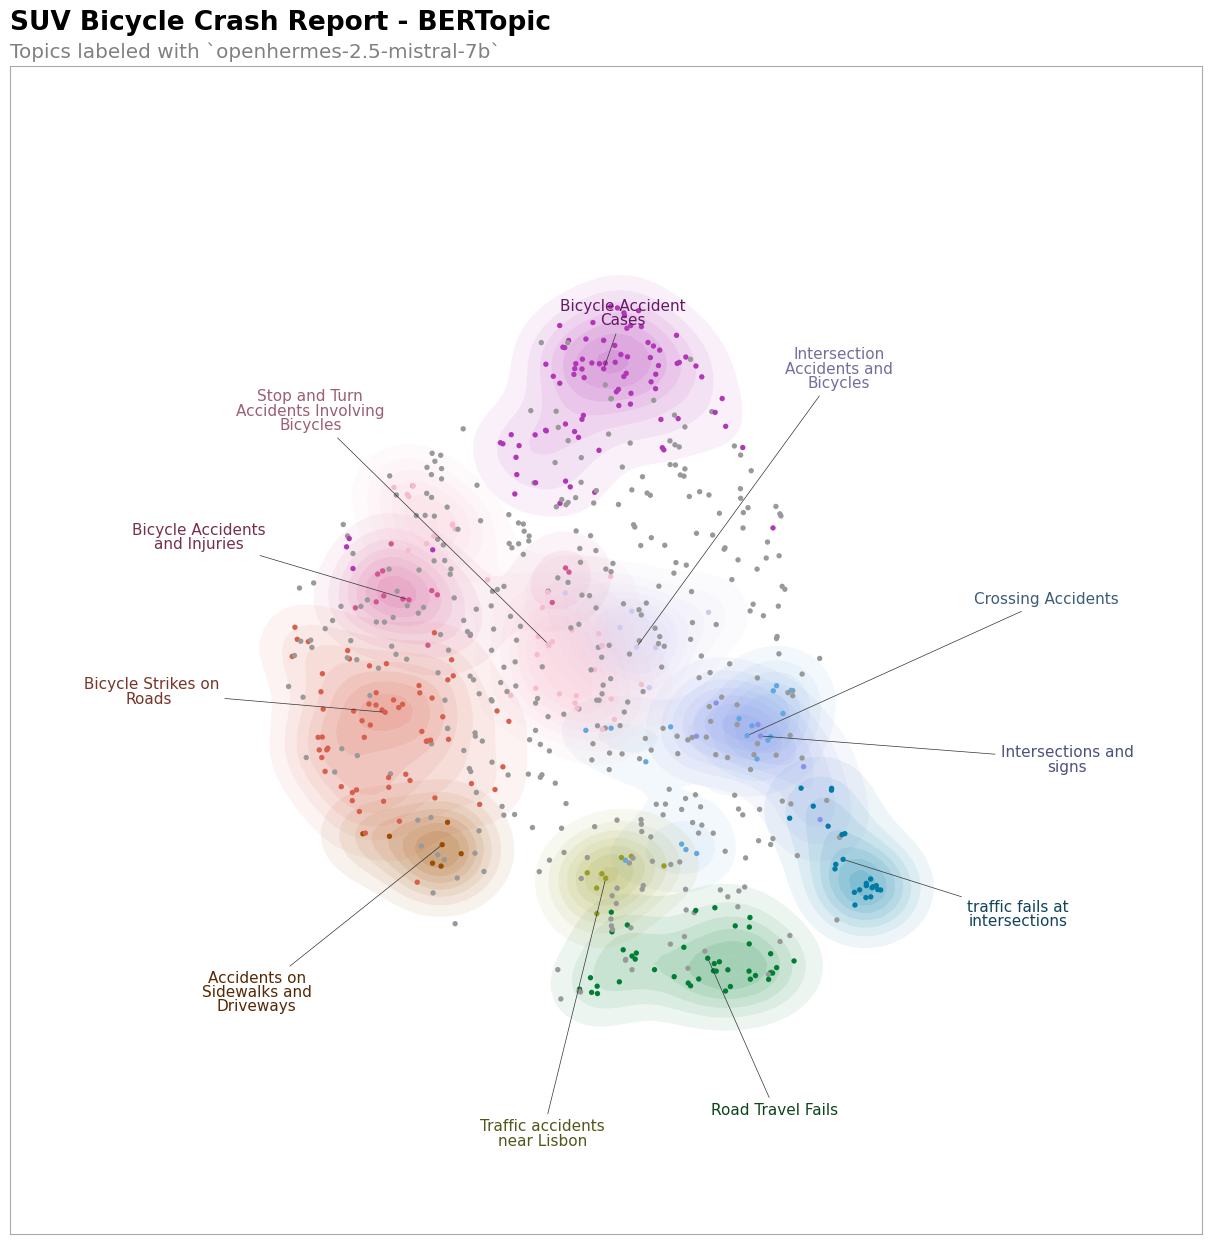

In [ ]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]
#topics, probs = topic_model.fit_transform(story_list)

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="SUV Bicycle Crash Report - BERTopic",
    sub_title="Topics labeled with `openhermes-2.5-mistral-7b`",
    label_wrap_width=20,
    use_medoids=True,
    #logo=bertopic_logo,
    #logo_width=0.16
)

In [ ]:
topic_model.visualize_barchart(top_n_topics = 50, custom_labels=True, width=300, height=300,)

In [ ]:
topic_model.visualize_heatmap( width=1000, height=1000, custom_labels=True)


In [ ]:
topic_model.visualize_topics(custom_labels=True)

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(story_list)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, custom_labels=True)

100%|██████████| 10/10 [00:00<00:00, 190.18it/s]


In [ ]:
timestamps = df.CRASH_YR.to_list()
timestamps = [int(year) for year in timestamps]
# Fit the model and transform the data
#topics, probs = topic_model.fit_transform(story_list)

In [ ]:
# Calculate topics over time

topics_over_time = topic_model.topics_over_time(story_list, timestamps,
                                                global_tuning=True, evolution_tuning=True, nr_bins=100)

# Visualize topics over time
topic_model.visualize_topics_over_time(topics_over_time, custom_labels=True)


5it [00:00, 34.04it/s]


### Metrics

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

# Assuming `story_list` is a list of documents
texts = [doc.split() for doc in story_list]

# Create a dictionary representation of the documents
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Convert BERTopic model topics to Gensim format
lda_topics = topic_model.get_topics()

# Create an LDA model using the BERTopic topics
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=len(lda_topics), passes=10, alpha='auto', eta='auto')

# Compute coherence score
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Compute perplexity
perplexity_score = lda_model.log_perplexity(corpus)

print(f"Coherence: {coherence_score}")
print(f"Perplexity: {perplexity_score}")


Coherence: 0.33569202196839476
Perplexity: -6.122895369071768


In [ ]:
from sklearn.metrics import silhouette_score
# Generate `X` and `labels` only for non-outlier topics (as they are technically not clusters)
umap_embeddings = topic_model.umap_model.transform(embeddings)
indices = [index for index, topic in enumerate(topics) if topic != -1]
X = umap_embeddings[np.array(indices)]
labels = [topic for index, topic in enumerate(topics) if topic != -1]

# Calculate silhouette score
silhouette_score(X, labels)


0.4127212

## Inference

### Prediction

In [ ]:
# Transform the data using the loaded model
df = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/SUV_Bicycle/processed_SUV.csv', encoding = 'latin1')
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Assign the topics to the dataframe
df['Topic'] = all_labels

# Display the topic distribution
print(df['Topic'].value_counts())

Unlabelled                                    387
Bicycle Accident Cases                         87
 Bicycle Strikes on Roads                      63
Road Travel Fails                              42
Stop and Turn Accidents Involving Bicycles     33
traffic fails at intersections                 24
Crossing Accidents                             18
Bicycle Accidents and Injuries                 15
Intersection Accidents and Bicycles             8
Traffic accidents near Lisbon                   8
Accidents on Sidewalks and Driveways            7
Intersections and signs                         6
Name: Topic, dtype: int64


In [ ]:
df['Topic_num'] = df['Topic']
# Get the topics and print them
unique_topics = df['Topic'].unique()


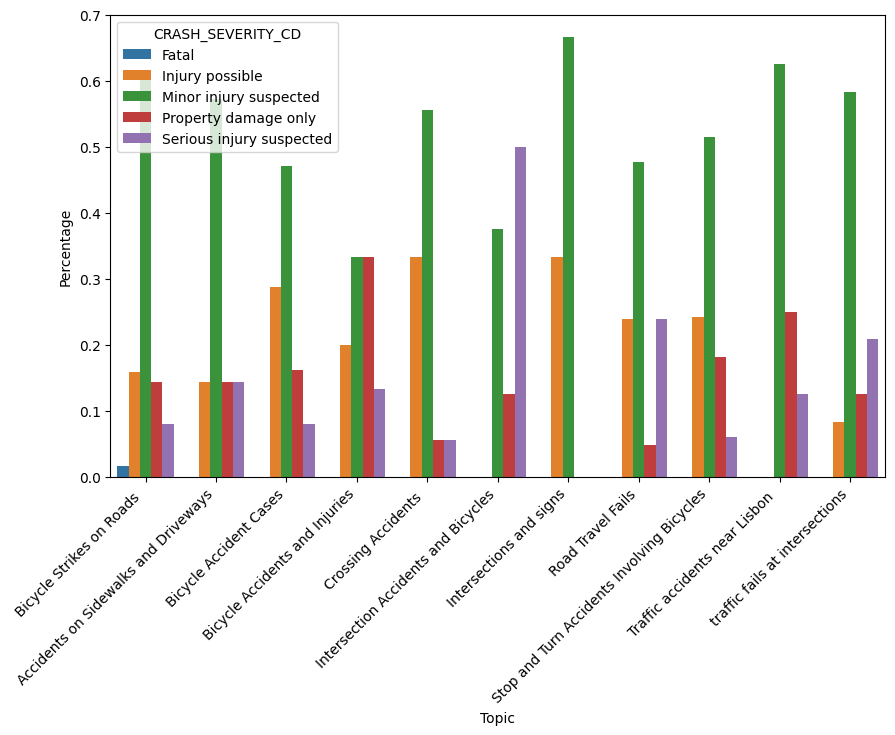

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df = df[df['Topic'] != 'Unlabelled']
# Identify the top 20 topics based on frequency
top_10_topics = df['Topic'].value_counts().index

# Filter the DataFrame for the top 20 topics
df_top_10_topics = df[df['Topic'].isin(top_10_topics)]

# Calculate the percentage of each crash severity category within each topic
percentage_df = df_top_10_topics.groupby(['Topic', 'CRASH_SEVERITY_CD']).size() / df_top_10_topics.groupby('Topic').size()
percentage_df = percentage_df.reset_index(name='Percentage')

# Create a percentage count plot for the top 20 topics with rotated x-axis labels
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.barplot(x='Topic', y='Percentage', hue='CRASH_SEVERITY_CD', data=percentage_df)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


In [ ]:
df.columns

Index(['Unnamed: 0', 'OBJECTID', 'DOCUMENT_NBR', 'CRASH_REPORT_LINK',
       'CRASH_YR', 'CRASH_MONTH_YEAR', 'DISTRICT_NBR', 'NLFID', 'NLF_JUR_CD',
       'NLF_COUNTY_CD',
       ...
       'U3_TYPE_OF_UNIT_CD', 'UNRESTRAIN_OCCUPANTS', 'WEATHER_COND_CD', 'V1',
       'Filter', 'fileNames', 'Narrative', 'clean_Narrative', 'Topic',
       'Topic_num'],
      dtype='object', length=157)

In [ ]:
df.head()

,Unnamed: 0,OBJECTID,DOCUMENT_NBR,CRASH_REPORT_LINK,CRASH_YR,CRASH_MONTH_YEAR,DISTRICT_NBR,NLFID,NLF_JUR_CD,NLF_COUNTY_CD,...,U3_TYPE_OF_UNIT_CD,UNRESTRAIN_OCCUPANTS,WEATHER_COND_CD,V1,Filter,fileNames,Narrative,clean_Narrative,Topic,Topic_num
1,1,186076084,20186076084,https://hsip.dot.state.oh.us/api/report/201860...,2018,5/1/2018 0:00,6,MFRAMR04337**C,M,FRA,...,NaN,0,Clear,NaN,WZ_Non_CMV,2018/pdf/186076084,"accident occurred on n. high st., at e. 1st av...",accident occur n st e ave northbound n st stat...,Bicycle Accident Cases,Bicycle Accident Cases
3,4,213093479,20213093479,https://hsip.dot.state.oh.us/api/report/202130...,2021,5/1/2021 0:00,8,SHAMUS00050**N,S,HAM,...,NaN,0,Clear,NaN,WZ_Non_CMV,2021/pdf/213093479,unit #1 was traveling soutbound on kemper ln c...,travel soutbound ln crossing columbia pkwy tr...,Bicycle Strikes on Roads,Bicycle Strikes on Roads
4,5,213229140,20213229140,https://hsip.dot.state.oh.us/api/report/202132...,2021,8/1/2021 0:00,8,SCLIUS00022**C,S,CLI,...,NaN,0,Clear,NaN,WZ_Non_CMV,2021/pdf/213229140,the driver of unit #1 stated she was in the le...,state left turn rombach avenue wait turn leav...,Bicycle Accident Cases,Bicycle Accident Cases
5,11,193113213,20193113213,https://hsip.dot.state.oh.us/api/report/201931...,2019,6/1/2019 0:00,12,CCUYCR00284**C,C,CUY,...,NaN,0,Clear,NaN,Non_WZ_CMV,2019/pdf/193113213,unit 1 stated:she was driving s b s. belvoir b...,state drive s s belvoir blvd second curb appr...,Bicycle Accident Cases,Bicycle Accident Cases
8,31,176022515,20176022515,https://hsip.dot.state.oh.us/api/report/201760...,2017,2/1/2017 0:00,11,SBELUS00040**C,S,BEL,...,NaN,0,Clear,NaN,Non_WZ_Non_CMV,2017/pdf/176022515,unit # 1 was traveling westbound on us-40. uni...,travel westbound us travel eastbound us fail ...,Road Travel Fails,Road Travel Fails


In [ ]:
df.to_csv('/content/drive/MyDrive/Subasish/CN_NLP/SUV_Bicycle/Topic_SUV.csv')

### Severity

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Subasish/CN_NLP/SUV_Bicycle/Topic_SUV.csv', encoding = 'latin1')
print(df['Topic'].value_counts())

Bicycle Accident Cases                        87
 Bicycle Strikes on Roads                     63
Road Travel Fails                             42
Stop and Turn Accidents Involving Bicycles    33
traffic fails at intersections                24
Crossing Accidents                            18
Bicycle Accidents and Injuries                15
Intersection Accidents and Bicycles            8
Traffic accidents near Lisbon                  8
Accidents on Sidewalks and Driveways           7
Intersections and signs                        6
Name: Topic, dtype: int64


In [ ]:
print(df['CRASH_SEVERITY_CD'].value_counts())

Minor injury suspected      161
Injury possible              67
Property damage only         44
Serious injury suspected     38
Fatal                         1
Name: CRASH_SEVERITY_CD, dtype: int64


In [ ]:
import pandas as pd


df['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Injury possible', 'Minor injury suspected')
df['CRASH_SEVERITY_CD'] = df['CRASH_SEVERITY_CD'].replace('Fatal', 'Serious injury suspected')
# Print the updated DataFrame
print(df['CRASH_SEVERITY_CD'].value_counts())


Minor injury suspected      228
Property damage only         44
Serious injury suspected     38
Fatal                         1
Name: CRASH_SEVERITY_CD, dtype: int64


In [ ]:
# Print the updated DataFrame
print(df['CRASH_SEVERITY_CD'].value_counts())

Minor injury suspected      228
Property damage only         44
Serious injury suspected     39
Name: CRASH_SEVERITY_CD, dtype: int64


In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'OBJECTID', 'DOCUMENT_NBR',
       'CRASH_REPORT_LINK', 'CRASH_YR', 'CRASH_MONTH_YEAR', 'DISTRICT_NBR',
       'NLFID', 'NLF_JUR_CD',
       ...
       'U3_TYPE_OF_UNIT_CD', 'UNRESTRAIN_OCCUPANTS', 'WEATHER_COND_CD', 'V1',
       'Filter', 'fileNames', 'Narrative', 'clean_Narrative', 'Topic',
       'Topic_num'],
      dtype='object', length=158)

Contingency Table:
CRASH_SEVERITY_CD                           Minor injury suspected  \
Topic                                                                
 Bicycle Strikes on Roads                                       48   
Accidents on Sidewalks and Driveways                             5   
Bicycle Accident Cases                                          66   
Bicycle Accidents and Injuries                                   8   
Crossing Accidents                                              16   
Intersection Accidents and Bicycles                              3   
Intersections and signs                                          6   
Road Travel Fails                                               30   
Stop and Turn Accidents Involving Bicycles                      25   
Traffic accidents near Lisbon                                    5   
traffic fails at intersections                                  16   

CRASH_SEVERITY_CD                           Property damage only  \
To

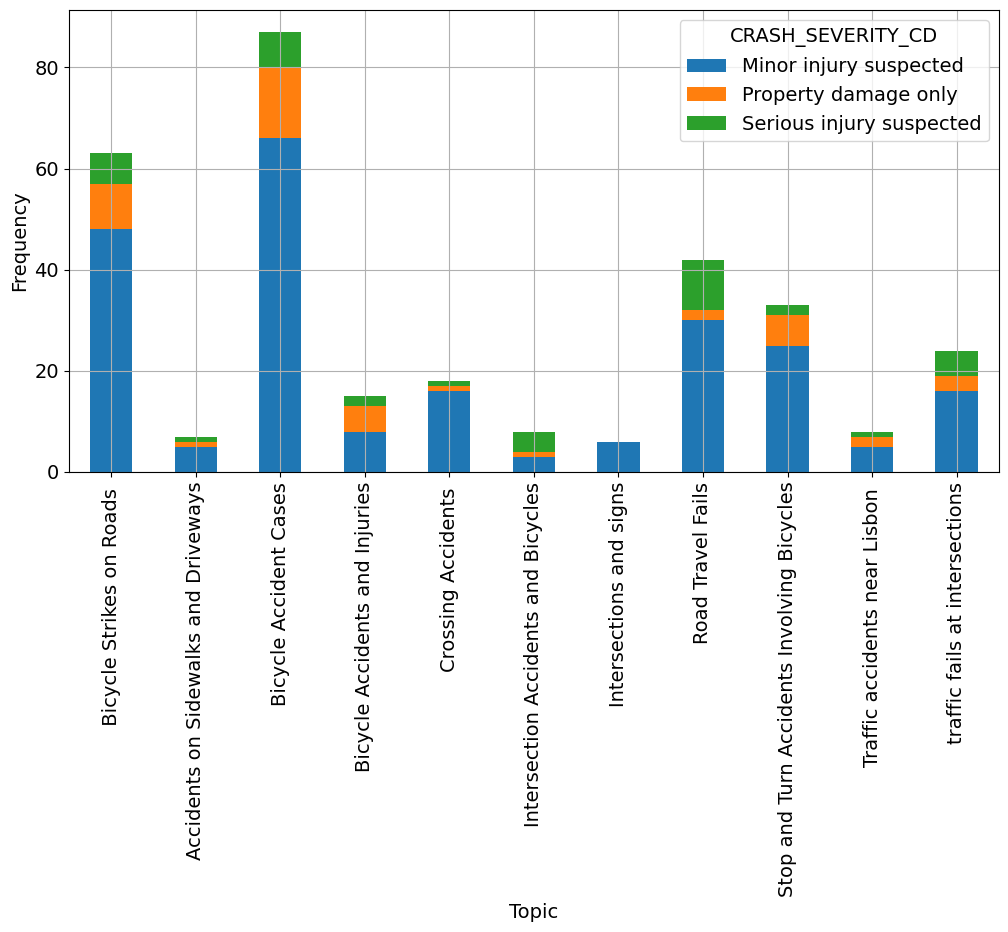

In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df'
# Replace column names with the actual column names in your DataFrame

# Create a contingency table
contingency_table = pd.crosstab(df['Topic'], df['CRASH_SEVERITY_CD'])

# Print the contingency table
print("Contingency Table:")
print(contingency_table)

# Plot the contingency table
contingency_table.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.legend(title='CRASH_SEVERITY_CD', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


In [ ]:

df['CRASH_YR'] = df['CRASH_YR'].astype(str)
# First, extract the 'base_predictions' and 'created_at' columns
sentiments_by_year = df[['CRASH_SEVERITY_CD', 'CRASH_YR']]

# Extract the year from the 'created_at' column and create a new column for it
sentiments_by_year['year'] = sentiments_by_year['CRASH_YR'].str[:4]

# Replace 'NaN' values in the 'year' column with 'no_date'
sentiments_by_year['year'].fillna('no_date', inplace=True)

# Group the data by 'year' and 'base_predictions', and then count the occurrences
sentiments_count_by_year = sentiments_by_year.groupby(['year', 'CRASH_SEVERITY_CD']).size().unstack(fill_value=0)

# Rename the columns for better clarity
sentiments_count_by_year.columns = ['Minor injury suspected', 'Property damage only', 'Serious injury suspected']

# Calculate the 'Total' column as the sum of Negative, Neutral, and Positive counts
sentiments_count_by_year['Total'] = sentiments_count_by_year[['Minor injury suspected', 'Property damage only', 'Serious injury suspected']].sum(axis=1)

# Convert the DataFrame to a new DataFrame with reset index
df_sentiments_count_by_year = pd.DataFrame(sentiments_count_by_year.reset_index())

# Add a row for the total count of each sentiment for all years
total_row = df_sentiments_count_by_year[['Minor injury suspected', 'Property damage only', 'Serious injury suspected', 'Total']].sum()
total_row['year'] = 'Total'
df_sentiments_count_by_year = df_sentiments_count_by_year.append(total_row, ignore_index=True)

# Display the new DataFrame
print(df_sentiments_count_by_year)
#df_sentiments_count_by_year.to_excel('/content/drive/MyDrive/Subasish/new_files_proccessed/CS/CS_base_year.xlsx', index=False)

    year  Minor injury suspected  Property damage only  \
0   2017                      14                     5   
1   2018                      55                    17   
2   2019                      44                     7   
3   2020                      55                     8   
4   2021                      60                     7   
5  Total                     228                    44   

   Serious injury suspected  Total  
0                         4     23  
1                         8     80  
2                         8     59  
3                        12     75  
4                         7     74  
5                        39    311  


<ipython-input-52-46085b80abc1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiments_by_year['year'] = sentiments_by_year['CRASH_YR'].str[:4]
<ipython-input-52-46085b80abc1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiments_by_year['year'].fillna('no_date', inplace=True)
<ipython-input-52-46085b80abc1>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_sentiments_count_by_year = df_sentiments_count_by_year.append(total_row, ignore_index=True)


In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df' and the column is 'CRASH_YR'
# Replace with the actual column names in your DataFrame

df['CRASH_YR'] = df['CRASH_YR'].astype(str)

# First, extract the 'Topic' and 'CRASH_YR' columns
topics_by_year = df[['Topic', 'CRASH_YR']]

# Extract the year from the 'CRASH_YR' column and create a new column for it
topics_by_year['year'] = topics_by_year['CRASH_YR'].str[:4]

# Replace 'NaN' values in the 'year' column with 'no_date'
topics_by_year['year'].fillna('no_date', inplace=True)

# Group the data by 'year' and 'Topic', and then count the occurrences
topics_count_by_year = topics_by_year.groupby(['year', 'Topic']).size().unstack(fill_value=0)

# Calculate the 'Total' column as the sum of counts for each topic
topics_count_by_year['Total'] = topics_count_by_year.sum(axis=1)

# Convert the DataFrame to a new DataFrame with reset index
df_topics_count_by_year = pd.DataFrame(topics_count_by_year.reset_index())

# Add a row for the total count of each topic for all years
total_row = df_topics_count_by_year[df_topics_count_by_year.columns[2:]].sum()
total_row['year'] = 'Total'
df_topics_count_by_year = df_topics_count_by_year.append(total_row, ignore_index=True)

# Display the new DataFrame
print(df_topics_count_by_year)


Topic   year   Bicycle Strikes on Roads   \
0       2017                         1.0   
1       2018                        16.0   
2       2019                        11.0   
3       2020                        18.0   
4       2021                        17.0   
5      Total                         NaN   

Topic  Accidents on Sidewalks and Driveways  Bicycle Accident Cases  \
0                                         0                       7   
1                                         2                      27   
2                                         1                      18   
3                                         3                      13   
4                                         1                      22   
5                                         7                      87   

Topic  Bicycle Accidents and Injuries  Crossing Accidents   \
0                                   2                    1   
1                                   4                    6   
2      

<ipython-input-53-6c1f546c25cc>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics_by_year['year'] = topics_by_year['CRASH_YR'].str[:4]
<ipython-input-53-6c1f546c25cc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics_by_year['year'].fillna('no_date', inplace=True)
<ipython-input-53-6c1f546c25cc>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_topics_count_by_year = df_topics_count_by_year.append(total_row, ignore_index=True)


<ipython-input-62-1455812cf63e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topics_by_year['year'] = topics_by_year['CRASH_YR'].dt.year


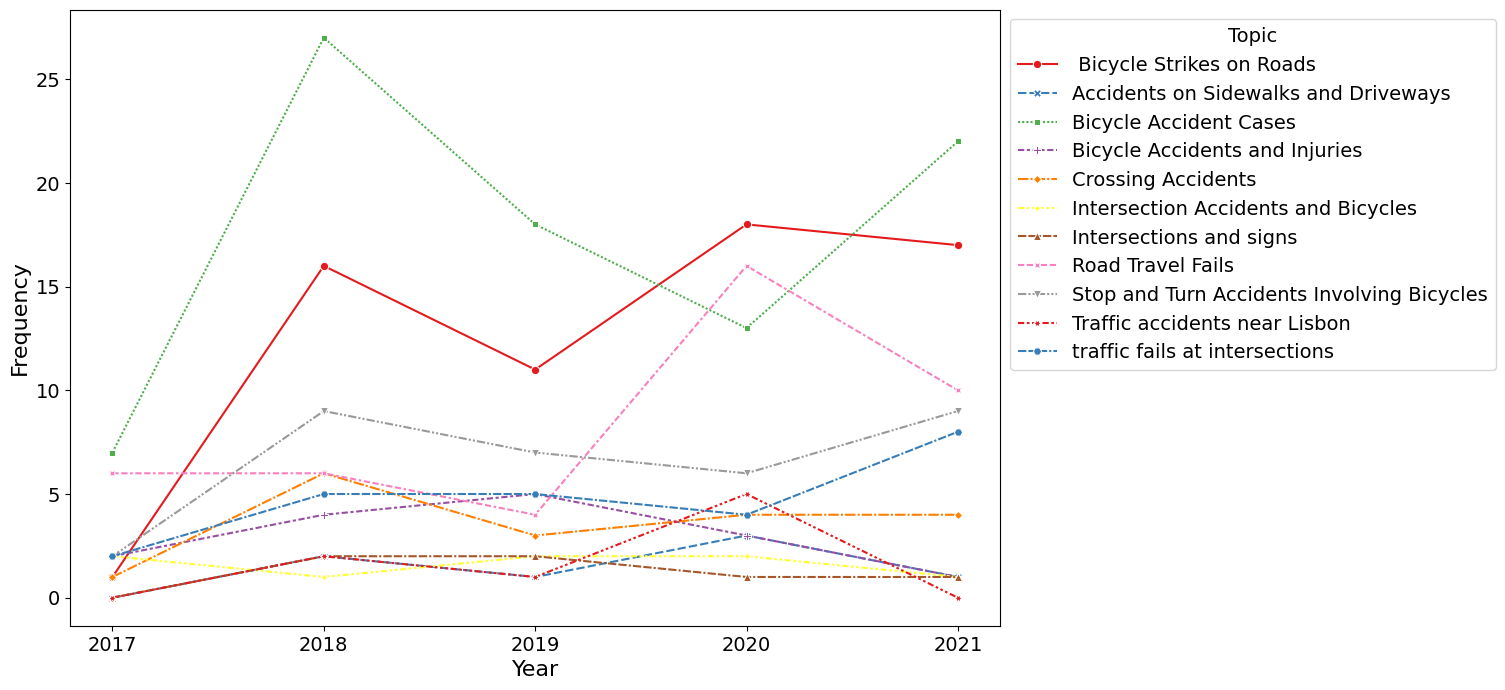

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named 'df'
# Replace column names with the actual column names in your DataFrame
df['CRASH_YR'] = pd.to_datetime(df['CRASH_YR'], format='%Y')

# Extract the 'Topic' and 'CRASH_YR' columns
topics_by_year = df[['Topic', 'CRASH_YR']]

# Extract the year from the 'CRASH_YR' column and create a new column for it
topics_by_year['year'] = topics_by_year['CRASH_YR'].dt.year

# Filter out the rows with .5 year values
topics_by_year = topics_by_year[topics_by_year['CRASH_YR'].dt.month == 1]

# Count the occurrences of each topic per year
topics_count_by_year = topics_by_year.groupby(['year', 'Topic']).size().unstack(fill_value=0)

# Set larger font size
plt.rcParams.update({'font.size': 14})

# Plot the line plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=topics_count_by_year, markers=True, palette='Set1')

# Set specific year labels
plt.xticks(range(2017, 2022))


plt.xlabel('Year', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(title='Topic', bbox_to_anchor=(1, 1), fontsize=14)
plt.show()


# Genism Benchmark

In [ ]:
!pip install octis

In [ ]:
import pandas as pd
from octis.dataset.dataset import Dataset
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel

import csv
from gensim import corpora, models
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

## LDA

In [ ]:



# Step 2: Load the 20Newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all')

# Tokenize the documents
tokenizer = RegexpTokenizer(r'\w+')
tokenized_documents = [tokenizer.tokenize(text.lower()) for text in newsgroups.data]

# Filter out empty documents
tokenized_documents = [doc for doc in tokenized_documents if doc]

# Step 4: Create a Bag of Words (BoW) representation
dictionary = corpora.Dictionary(tokenized_documents)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Check if there are any documents to proceed with the LDA model
if not corpus:
    print("No documents to analyze.")
else:
    # Loop over different numbers of topics
    for num_topics in range(5, 16):
        # Train the LDA model
        lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=5)

        # Evaluate coherence and perplexity
        coherence_model_lda = models.CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()

        perplexity = lda_model.log_perplexity(corpus)

        # Save the results
        result = {'Num_Topics': num_topics, 'Coherence_Score': coherence_lda, 'Perplexity': perplexity}

        # Print fields
        if num_topics == 5:
            print("Fields:", ', '.join(result.keys()))

        print(result)

        # Save results to CSV file
        csv_file_path = 'lda_results.csv'
        fieldnames = ['Num_Topics', 'Coherence_Score', 'Perplexity']

        with open(csv_file_path, 'a', newline='') as csv_file:
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

            # Write data
            writer.writerow(result)

    print(f'Results saved to {csv_file_path}.')





Fields: Num_Topics, Coherence_Score, Perplexity
{'Num_Topics': 5, 'Coherence_Score': 0.559306501592153, 'Perplexity': -7.706607095498765}
{'Num_Topics': 6, 'Coherence_Score': 0.5647692375568574, 'Perplexity': -7.732488687807931}
{'Num_Topics': 7, 'Coherence_Score': 0.628651168421727, 'Perplexity': -7.789810326316457}
{'Num_Topics': 8, 'Coherence_Score': 0.5758778424203738, 'Perplexity': -7.88393898205925}
{'Num_Topics': 9, 'Coherence_Score': 0.5295140239485402, 'Perplexity': -7.976187874296}
{'Num_Topics': 10, 'Coherence_Score': 0.49794221922840765, 'Perplexity': -8.067611710081636}
{'Num_Topics': 11, 'Coherence_Score': 0.5340058090270503, 'Perplexity': -8.138582600430423}
{'Num_Topics': 12, 'Coherence_Score': 0.49481841289111567, 'Perplexity': -8.227511620659856}
{'Num_Topics': 13, 'Coherence_Score': 0.606222933248844, 'Perplexity': -8.271111328430706}
{'Num_Topics': 14, 'Coherence_Score': 0.4933540068047583, 'Perplexity': -8.353820589711832}
{'Num_Topics': 15, 'Coherence_Score': 0.55

In [ ]:

'''

# Define dataset
dataset = Dataset()
dataset.fetch_dataset("20NewsGroup")

# Create an empty DataFrame to store results
result_df = pd.DataFrame(columns=['NumTopics', 'Perplexity', 'Coherence'])

# Loop through different numbers of topics
for num_topics in range(5, 16):
    print(f"\nNumber of Topics: {num_topics}")

    # Create a dictionary representation of the documents
    dictionary = Dictionary(dataset.get_corpus())
    corpus = [dictionary.doc2bow(text) for text in dataset.get_corpus()]

    # Create an LDA model using the Octis model
    model = LDA(num_topics=num_topics, alpha=0.1)

    # Train the model using the Octis dataset
    output = model.train_model(dataset)

    # Convert Octis model topics to Gensim format
    lda_topics = output['topics']

    # Create an LDA model using the Octis topics
    lda_model = LdaModel(corpus, id2word=dictionary, num_topics=len(lda_topics), passes=20, alpha='auto', eta='auto')

    # Compute perplexity
    perplexity_score = lda_model.log_perplexity(corpus)
    print(f"LDA Perplexity: {perplexity_score}")

    # Initialize metric
    npmi = Coherence(texts=dataset.get_corpus(), topk=10, measure='c_npmi')

    # Retrieve metrics scores
    npmi_score = npmi.score(output)
    print("LDA Coherence: " + str(npmi_score))

    # Append results to DataFrame
    result_df = result_df.append({'NumTopics': num_topics, 'Perplexity': perplexity_score, 'Coherence': npmi_score}, ignore_index=True)

# Save the results to a CSV file
result_df.to_csv('lda_results.csv', index=False)
'''

## BERTopic + Llama

In [ ]:

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, LlamaCPP
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from octis.dataset.dataset import Dataset
from cuml.cluster import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel

# Define dataset
dataset = Dataset()
dataset.fetch_dataset("20NewsGroup")

# Preprocess data for BERTopic
docs = dataset.get_corpus()

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=6, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Representation model
prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

# BERTopic model
bertopic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    top_n_words=10,
    nr_topics=11,
    verbose=True
)
# Convert all elements in docs to strings
docs = [str(doc) for doc in docs]

# Truncate each document to a maximum number of tokens
max_tokens = 2500
truncated_docs = [doc[:max_tokens] for doc in docs]

# Create a list to store results
results_list = []

# Loop over nr_topics from 5 to 15
for nr_topics in range(5, 16):
    # Update BERTopic model with the current nr_topics
    bertopic_model.nr_topics = nr_topics

    # Train BERTopic model with the modified documents
    bertopic_topics, bertopic_probs = bertopic_model.fit_transform(truncated_docs, embeddings)
    # Assuming `story_list` is a list of documents
    texts = [doc.split() for doc in docs]

    # Create a dictionary representation of the documents
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    # Convert BERTopic model topics to Gensim format
    lda_topics = bertopic_model.get_topics()

    # Create an LDA model using the BERTopic topics
    lda_model = LdaModel(corpus, id2word=dictionary, num_topics=len(lda_topics), passes=10, alpha='auto', eta='auto')

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    # Compute perplexity
    perplexity_score = lda_model.log_perplexity(corpus)
    print(f"Coherence: {coherence_score}")
    print(f"Perplexity: {perplexity_score}")
    # Append results to the list
    results_list.append({
        'nr_topics': nr_topics,
        'coherence': coherence_score,
        'perplexity': perplexity_score
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Save the results to a CSV file
results_df.to_csv('bertopic_results.csv', index=False)

print("Results saved to 'bertopic_results.csv'")

Batches:   0%|          | 0/510 [00:00<?, ?it/s]

2024-02-03 20:35:04,018 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-03 20:35:04,328 - BERTopic - Dimensionality - Completed ✓
2024-02-03 20:35:04,331 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-03 20:35:04,638 - BERTopic - Cluster - Completed ✓
2024-02-03 20:35:04,640 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 470/470 [15:47<00:00,  2.02s/it]
2024-02-03 20:51:15,209 - BERTopic - Representation - Completed ✓
2024-02-03 20:51:15,216 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 5/5 [00:17<00:00,  3.41s/it]
2024-02-03 20:51:35,018 - BERTopic - Topic reduction - Reduced number of topics from 470 to 5
2024-02-03 20:52:57,458 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Coherence: 0.4772452924571072
Perplexity: -6.959069673660524


2024-02-03 20:52:57,844 - BERTopic - Dimensionality - Completed ✓
2024-02-03 20:52:57,850 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-03 20:52:58,131 - BERTopic - Cluster - Completed ✓
2024-02-03 20:52:58,133 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 455/455 [15:31<00:00,  2.05s/it]
2024-02-03 21:08:52,280 - BERTopic - Representation - Completed ✓
2024-02-03 21:08:52,282 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 6/6 [00:22<00:00,  3.75s/it]
2024-02-03 21:09:17,401 - BERTopic - Topic reduction - Reduced number of topics from 455 to 6
2024-02-03 21:10:42,223 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Coherence: 0.46638772964193337
Perplexity: -6.962133586828883


2024-02-03 21:10:42,585 - BERTopic - Dimensionality - Completed ✓
2024-02-03 21:10:42,589 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-03 21:10:42,948 - BERTopic - Cluster - Completed ✓
2024-02-03 21:10:42,954 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 464/464 [15:52<00:00,  2.05s/it]
2024-02-03 21:27:00,110 - BERTopic - Representation - Completed ✓
2024-02-03 21:27:00,112 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 7/7 [00:20<00:00,  2.87s/it]
2024-02-03 21:27:22,291 - BERTopic - Topic reduction - Reduced number of topics from 464 to 7
2024-02-03 21:28:50,607 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Coherence: 0.493929278813188
Perplexity: -6.945267875655745


2024-02-03 21:28:51,002 - BERTopic - Dimensionality - Completed ✓
2024-02-03 21:28:51,004 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-03 21:28:51,296 - BERTopic - Cluster - Completed ✓
2024-02-03 21:28:51,298 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 463/463 [15:49<00:00,  2.05s/it]
2024-02-03 21:45:05,451 - BERTopic - Representation - Completed ✓
2024-02-03 21:45:05,453 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 8/8 [00:26<00:00,  3.27s/it]
2024-02-03 21:45:33,911 - BERTopic - Topic reduction - Reduced number of topics from 463 to 8
2024-02-03 21:47:06,325 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Coherence: 0.5184522310344942
Perplexity: -6.9371839472836605


2024-02-03 21:47:06,693 - BERTopic - Dimensionality - Completed ✓
2024-02-03 21:47:06,695 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-03 21:47:06,998 - BERTopic - Cluster - Completed ✓
2024-02-03 21:47:07,003 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 453/453 [15:52<00:00,  2.10s/it]
2024-02-03 22:03:24,116 - BERTopic - Representation - Completed ✓
2024-02-03 22:03:24,121 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 9/9 [00:29<00:00,  3.25s/it]
2024-02-03 22:03:56,288 - BERTopic - Topic reduction - Reduced number of topics from 453 to 9
2024-02-03 22:05:21,915 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Coherence: 0.5567375558933398
Perplexity: -6.934171990514398


2024-02-03 22:05:22,299 - BERTopic - Dimensionality - Completed ✓
2024-02-03 22:05:22,301 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-03 22:05:22,713 - BERTopic - Cluster - Completed ✓
2024-02-03 22:05:22,718 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 466/466 [15:49<00:00,  2.04s/it]
2024-02-03 22:21:35,064 - BERTopic - Representation - Completed ✓
2024-02-03 22:21:35,067 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 10/10 [00:33<00:00,  3.33s/it]
2024-02-03 22:22:10,622 - BERTopic - Topic reduction - Reduced number of topics from 466 to 10
2024-02-03 22:23:41,641 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Coherence: 0.5236442569583878
Perplexity: -6.965479145338869


2024-02-03 22:23:42,013 - BERTopic - Dimensionality - Completed ✓
2024-02-03 22:23:42,018 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-03 22:23:42,316 - BERTopic - Cluster - Completed ✓
2024-02-03 22:23:42,317 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 466/466 [15:44<00:00,  2.03s/it]
2024-02-03 22:39:50,096 - BERTopic - Representation - Completed ✓
2024-02-03 22:39:50,098 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 11/11 [00:35<00:00,  3.22s/it]
2024-02-03 22:40:27,677 - BERTopic - Topic reduction - Reduced number of topics from 466 to 11
2024-02-03 22:41:53,085 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Coherence: 0.5759080292380583
Perplexity: -6.971490187931377


2024-02-03 22:41:53,423 - BERTopic - Dimensionality - Completed ✓
2024-02-03 22:41:53,425 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-03 22:41:53,770 - BERTopic - Cluster - Completed ✓
2024-02-03 22:41:53,775 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 464/464 [15:45<00:00,  2.04s/it]
2024-02-03 22:58:03,056 - BERTopic - Representation - Completed ✓
2024-02-03 22:58:03,058 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 12/12 [00:37<00:00,  3.15s/it]
2024-02-03 22:58:43,515 - BERTopic - Topic reduction - Reduced number of topics from 464 to 12
2024-02-03 23:00:15,424 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Coherence: 0.5655875458464623
Perplexity: -6.992828721435553


2024-02-03 23:00:15,792 - BERTopic - Dimensionality - Completed ✓
2024-02-03 23:00:15,797 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-03 23:00:16,173 - BERTopic - Cluster - Completed ✓
2024-02-03 23:00:16,176 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 468/468 [15:54<00:00,  2.04s/it]
2024-02-03 23:16:34,045 - BERTopic - Representation - Completed ✓
2024-02-03 23:16:34,047 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 13/13 [00:36<00:00,  2.83s/it]
2024-02-03 23:17:13,208 - BERTopic - Topic reduction - Reduced number of topics from 468 to 13
2024-02-03 23:18:46,236 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Coherence: 0.5663916309351686
Perplexity: -6.993165061338162


2024-02-03 23:18:46,568 - BERTopic - Dimensionality - Completed ✓
2024-02-03 23:18:46,572 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-03 23:18:46,853 - BERTopic - Cluster - Completed ✓
2024-02-03 23:18:46,857 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 466/466 [16:00<00:00,  2.06s/it]
2024-02-03 23:35:10,242 - BERTopic - Representation - Completed ✓
2024-02-03 23:35:10,245 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 14/14 [00:38<00:00,  2.75s/it]
2024-02-03 23:35:52,228 - BERTopic - Topic reduction - Reduced number of topics from 466 to 14
2024-02-03 23:37:25,382 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Coherence: 0.5699819595268246
Perplexity: -6.99968937541126


2024-02-03 23:37:25,722 - BERTopic - Dimensionality - Completed ✓
2024-02-03 23:37:25,724 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-03 23:37:26,008 - BERTopic - Cluster - Completed ✓
2024-02-03 23:37:26,012 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 456/456 [15:38<00:00,  2.06s/it]
2024-02-03 23:53:27,066 - BERTopic - Representation - Completed ✓
2024-02-03 23:53:27,068 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 15/15 [00:39<00:00,  2.61s/it]
2024-02-03 23:54:08,561 - BERTopic - Topic reduction - Reduced number of topics from 456 to 15


Coherence: 0.5635709667837097
Perplexity: -7.010924988413873
Results saved to 'bertopic_results.csv'


In [ ]:
'''

# Define dataset
dataset = Dataset()
dataset.fetch_dataset("20NewsGroup")

# Preprocess data for BERTopic
docs = dataset.get_corpus()

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=6, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Representation model
prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

# Create an empty DataFrame to store results
result_df_bertopic = pd.DataFrame(columns=['NumTopics', 'Perplexity', 'Coherence'])

# Loop through different numbers of topics
for num_topics in range(5, 16):
    print(f"\nNumber of Topics: {num_topics}")

    # BERTopic model
    bertopic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        representation_model=representation_model,
        top_n_words=10,
        nr_topics=num_topics,
        verbose=True
    )

    # Convert all elements in docs to strings
    docs = [str(doc) for doc in docs]

    # Truncate each document to a maximum number of tokens
    max_tokens = 2500
    truncated_docs = [doc[:max_tokens] for doc in docs]

    # Train BERTopic model with the modified documents
    bertopic_topics, bertopic_probs = bertopic_model.fit_transform(truncated_docs, embeddings)

    # Compute perplexity
    perplexity_score = bertopic_model.get_perplexity()

    # Compute coherence score
    coherence_model = CoherenceModel(model=bertopic_model, texts=truncated_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    # Append results to DataFrame
    result_df_bertopic = result_df_bertopic.append({'NumTopics': num_topics, 'Perplexity': perplexity_score, 'Coherence': coherence_score}, ignore_index=True)

# Save the results to a CSV file
result_df_bertopic.to_csv('bertopic_results.csv', index=False)
'''

In [ ]:
import pandas as pd

# Load the results from LDA and BERTopic
result_df_lda = pd.read_csv('lda_results.csv')
result_df_bertopic = pd.read_csv('bertopic_results.csv')

# Merge DataFrames on 'NumTopics'
merged_df = pd.merge(result_df_lda, result_df_bertopic, on='NumTopics', suffixes=('_LDA', '_BERTopic'))

# Display the comparison table
print(merged_df)


## Benchmark Visualizatons

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
'''
# Load LDA data from CSV
lda_results = pd.read_csv('lda_results.csv')
lda_num_topics = lda_results['NumTopic']
lda_coherence = lda_results['Coherence']

# Load BERTopic data from CSV
bertopic_results = pd.read_csv('bertopic_results.csv')
bertopic_num_topics = bertopic_results['nr_topics']
bertopic_coherence = bertopic_results['coherence']

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(lda_num_topics, lda_coherence, label='LDA')
plt.plot(bertopic_num_topics, bertopic_coherence, label='BERTopic')

plt.title('Coherence vs Topic Count', fontsize=16)
plt.xlabel('Number of Topics', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)

# Increase font size of tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()
'''

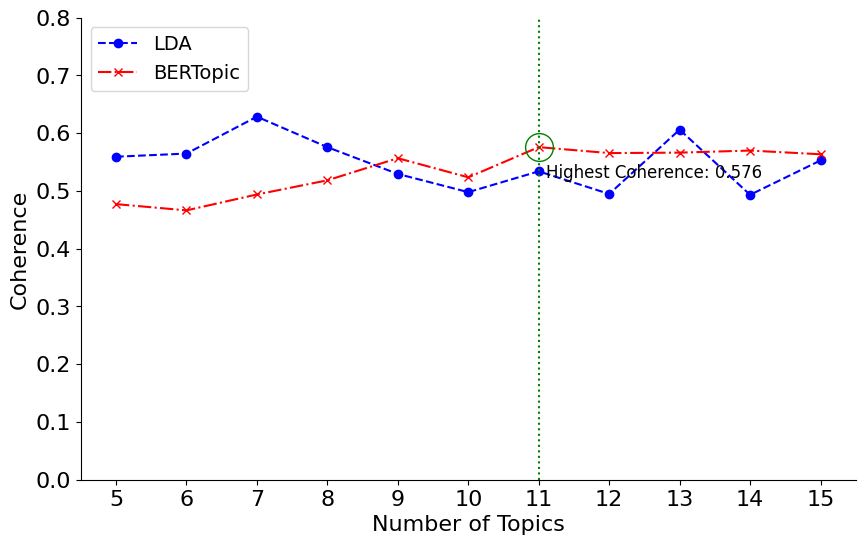

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Load LDA data from CSV
lda_results = pd.read_csv('lda_results.csv')
lda_num_topics = lda_results['NumTopic']
lda_coherence = lda_results['Coherence']

# Load BERTopic data from CSV
bertopic_results = pd.read_csv('bertopic_results.csv')
bertopic_num_topics = bertopic_results['nr_topics']
bertopic_coherence = bertopic_results['coherence']

# Plotting with modifications
plt.figure(figsize=(10, 6))

# Modified LDA plot with specific line style and marker
plt.plot(lda_num_topics, lda_coherence, label='LDA', linestyle='--', marker='o', color='blue')

# Modified BERTopic plot with different line style and marker
plt.plot(bertopic_num_topics, bertopic_coherence, label='BERTopic', linestyle='-.', marker='x', color='red')

# plt.title('Coherence vs Topic Count', fontsize=16)
plt.xlabel('Number of Topics', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=14)

# Placing the legend in the upper left corner
plt.legend(loc='upper left', fontsize=14)

# Removing the grid behind
plt.grid(False)

# Only show bottom and left axis, hide top and right axis
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim(0, 0.8)

# Set x-axis ticks with an increment of 1
plt.xticks(range(int(min(lda_num_topics)), int(max(lda_num_topics))+1, 1), fontsize=16)
plt.yticks(fontsize=16)

# Make axvline at the highest coherence value and put text "Best"
highest_coherence_value = max(bertopic_coherence)
best_coherence_index = np.argmax(bertopic_coherence) + 5  # Assuming you want to mark the best for BERTopic
plt.axvline(x=best_coherence_index, color='green', linestyle=':', label='Best Coherence')

# Insert marker for highlight
marker_size = 20  # Adjust the size as needed
plt.plot(best_coherence_index, highest_coherence_value, marker='o', markerfacecolor='none', markeredgecolor='green', markersize=marker_size, linestyle='None', label='Best Coherence')


# Adjusting text position with offsets
x_offset = 0.1
y_offset = - 0.06


plt.text(best_coherence_index + x_offset, highest_coherence_value + y_offset, f'Highest Coherence: {np.round(highest_coherence_value,3)}', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
'''
# Load LDA data from CSV
lda_results = pd.read_csv('lda_results.csv')
lda_num_topics = lda_results['NumTopic']
lda_perplexity_abs = abs(lda_results['Perplexity'])

# Load BERTopic data from CSV
bertopic_results = pd.read_csv('bertopic_results.csv')
bertopic_num_topics = bertopic_results['nr_topics']
bertopic_perplexity_abs = abs(bertopic_results['perplexity'])

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(lda_num_topics, lda_perplexity_abs, label='LDA')
plt.plot(bertopic_num_topics, bertopic_perplexity_abs, label='BERTopic')

plt.title('Perplexity vs Topic Count', fontsize=16)
plt.xlabel('Number of Topics', fontsize=16)
plt.ylabel('Perplexity', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)

# Increase font size of tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()
'''

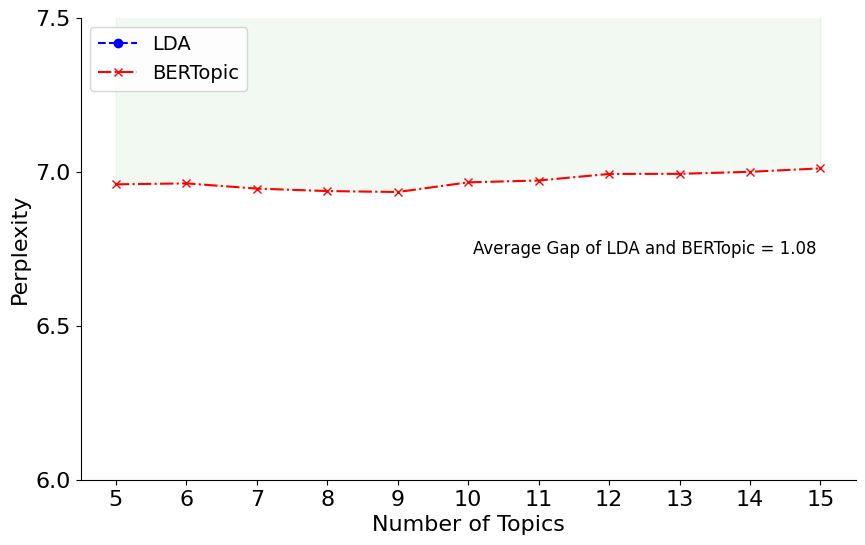

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load LDA data from CSV
lda_results = pd.read_csv('lda_results.csv')
lda_num_topics = lda_results['NumTopic']
lda_perplexity_abs = abs(lda_results['Perplexity'])

# Load BERTopic data from CSV
bertopic_results = pd.read_csv('bertopic_results.csv')
bertopic_num_topics = bertopic_results['nr_topics']
bertopic_perplexity_abs = abs(bertopic_results['perplexity'])

# Plotting with improvements
plt.figure(figsize=(10, 6))
plt.ylim(6, 7.5)


# Adjust y-axis to increment every 0.5
plt.yticks(np.arange(6, 7.5 + 0.5, 0.5))
plt.xticks(np.arange(5, 16, 1))

# Only show bottom and left axis, hide top and right axis
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Apply different line styles and markers
plt.plot(lda_num_topics, lda_perplexity_abs, label='LDA', linestyle='--', marker='o', color='blue')
plt.plot(bertopic_num_topics, bertopic_perplexity_abs, label='BERTopic', linestyle='-.', marker='x', color='red')
plt.xlabel('Number of Topics', fontsize=16)
plt.ylabel('Perplexity', fontsize=16)
plt.legend(loc='upper left', fontsize=14)

# Calculate the width (difference) between the two lines at each data point
differences = np.abs(lda_perplexity_abs - bertopic_perplexity_abs)

# Calculate the average width
average_width = np.mean(differences)

# Fill the region between the two lines
plt.fill_between(lda_num_topics, lda_perplexity_abs, bertopic_perplexity_abs, color='green', alpha=0.05, label='Filled Region')

# Add the average width as text in the filled region
plt.text(12.5, 6.75, f'Average Gap of LDA and BERTopic = {average_width:.2f}', fontsize=12, ha='center', va='center', color='black')

# Rest of your plotting code


# Remove the grid
plt.grid(False)

# Increase font size of tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()